In [1]:
import sys, os, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import logging
# from scipy.interpolate import UnivariateSpline, interp1d
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.libqsturng import psturng
import scipy.stats as stats

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

%matplotlib inline
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['pdf.fonttype'] = 42

# make a folder to store figures if not already there
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [2]:
# Facility Functions

def tukeyTest(data, groups, alpha=0.05):
    '''Perform pairwise Tukey test for the data by groups
    '''
    # pairwise comparisons using Tukey's test, calculating p-values
    res = pairwise_tukeyhsd(data, groups, alpha)
    print("Summary of test:\n", res)
    # print(dir(results))# prints out all attributes of an object
    pVal = psturng(np.abs(res.meandiffs / res.std_pairs), len(res.groupsunique), res.df_total)
    print("p values of all pair-wise tests:\n", pVal)

    return res


In [3]:
# Read in Western blot quantification spreadsheet that was exported from ImageStudio Lite
# and cleaned up in Excel.
#
# Note taht for LI-COR Western it is most appropriate to quantify in the ImageStudio software
# to capitalize on the 32-bit image. If quantifying in ImageJ, make sure to include a standard
# curve of the control, typically in serial dilutions.

folder = '../data/DLD-1-Western-and-IF-data/'
f = folder + 'DLD-1-Western-quantification-sg-control-sg1-sg2-Cdh1-5day-DMSO-ABA.csv'
df = pd.read_csv(f, header=0)

df.dropna(inplace=True)

df['groups'] = [df.sgRNA.iloc[i] + '-' + df.Treatment.iloc[i] for i in range(len(df))]

df.head()


,Dataset_date,sgRNA,Ab,Days,Treatment,Signal,Total,Area,Bkgnd.,Ecad_to_GAPDH,Normed_Ecad_to_GAPDH,groups
0,20191109,sg-Control,E-cad,5,DMSO,111.00,376,324,0.819,0.014683,1.000000,sg-Control-DMSO
2,20191109,sg-Control,E-cad,5,ABA,97.70,282,230,0.800,0.014368,0.978553,sg-Control-ABA
4,20191109,sg1-Cdh1,E-cad,5,DMSO,50.00,253,250,0.812,0.009363,0.637716,sg1-Cdh1-DMSO
6,20191109,sg1-Cdh1,E-cad,5,ABA,6.74,294,351,0.819,0.001072,0.072981,sg1-Cdh1-ABA
8,20191109,sg2-Cdh1,E-cad,5,DMSO,15.50,237,264,0.837,0.002627,0.178928,sg2-Cdh1-DMSO


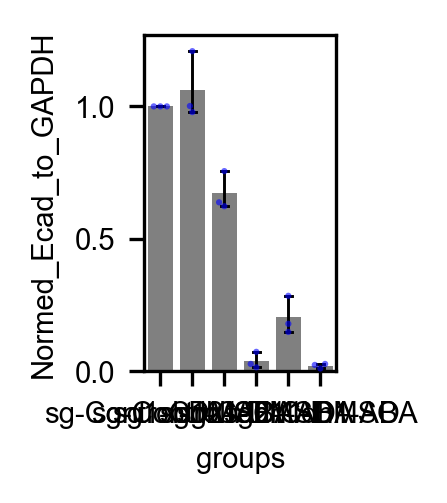

In [4]:
outputPrefix = 'DLD-1-Western-quantification-Ecad'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
# plotDensityBarSwarm(df.sgRNA, df.Normed_Ecad_to_GAPDH,
# #                     outputFigPath,
# #                     yTickSpacing=30, yMax=160,
#                    fig_width=0.7, fig_height=1.0)

fig_width=0.8
fig_height=1.4
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(x='groups', y='Normed_Ecad_to_GAPDH', data=df,
                   color="blue", size=1.5, alpha=.6)

ax = sns.barplot(x='groups', y='Normed_Ecad_to_GAPDH', data=df,
                 color="Gray", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci=95)

# plt.ylim(0, yMax)
# plt.yticks(yTicks)

# plt.xlabel(None)
# plt.ylabel("Attached cells / mm2")

# ax.set_xticklabels(labels=plot_order, rotation=45, ha="right")

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [5]:
tukeyTest(df.Normed_Ecad_to_GAPDH, df.groups)


Summary of test:
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
 sg-Control-ABA sg-Control-DMSO  -0.0628 0.8422 -0.2485  0.1228  False
 sg-Control-ABA    sg1-Cdh1-ABA  -1.0245  0.001 -1.2102 -0.8389   True
 sg-Control-ABA   sg1-Cdh1-DMSO  -0.3908  0.001 -0.5764 -0.2051   True
 sg-Control-ABA    sg2-Cdh1-ABA  -1.0424  0.001 -1.2281 -0.8568   True
 sg-Control-ABA   sg2-Cdh1-DMSO   -0.859  0.001 -1.0446 -0.6733   True
sg-Control-DMSO    sg1-Cdh1-ABA  -0.9617  0.001 -1.1474 -0.7761   True
sg-Control-DMSO   sg1-Cdh1-DMSO  -0.3279  0.001 -0.5136 -0.1423   True
sg-Control-DMSO    sg2-Cdh1-ABA  -0.9796  0.001 -1.1652 -0.7939   True
sg-Control-DMSO   sg2-Cdh1-DMSO  -0.7961  0.001 -0.9818 -0.6105   True
   sg1-Cdh1-ABA   sg1-Cdh1-DMSO   0.6338  0.001  0.4481  0.8194   True
   sg1-Cdh1-ABA    sg2-Cdh1-ABA  -0.0179    0.9 -0.2035  0.

In [6]:
by_group = df.groupby('groups')
by_group['Normed_Ecad_to_GAPDH'].describe()


,count,mean,std,min,25%,50%,75%,max
groups,,,,,,,,
sg-Control-ABA,3.0,1.062831,0.126696,0.978553,0.989981,1.001408,1.104969,1.208531
sg-Control-DMSO,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
sg1-Cdh1-ABA,3.0,0.038287,0.030719,0.014544,0.020940,0.027337,0.050159,0.072981
sg1-Cdh1-DMSO,3.0,0.672079,0.072669,0.622964,0.630340,0.637716,0.696636,0.755556
sg2-Cdh1-ABA,3.0,0.020401,0.008908,0.010337,0.016967,0.023597,0.025433,0.027270
sg2-Cdh1-DMSO,3.0,0.203852,0.071606,0.148039,0.163484,0.178928,0.231759,0.284589


In [7]:
# Integrin beta1 mAb13 blotting without median filtering
sg_control_ABA_ITGB1 = 90.8
sg_control_ABA_GAPDH = 28400
sg_Itgb1_ABA_ITGB1 = 14.2
sg_Itgb1_ABA_GAPDH = 23600
sg_control_rel = sg_control_ABA_ITGB1 / sg_control_ABA_GAPDH
sg_Itgb1_rel = sg_Itgb1_ABA_ITGB1 / sg_Itgb1_ABA_GAPDH
ratio = sg_Itgb1_rel / sg_control_rel
print('Normalized amount of integrin b1 in sg-Itgb1 vs. sg-Control: ', ratio)


Normalized amount of integrin b1 in sg-Itgb1 vs. sg-Control:  0.18819532591652355


In [8]:
# Integrin beta1 mAb13 blotting with median filtering
sg_control_ABA_ITGB1 = 163610
sg_control_ABA_GAPDH = 28400
sg_Itgb1_ABA_ITGB1 = -31127
sg_Itgb1_ABA_GAPDH = 23600
sg_control_rel = sg_control_ABA_ITGB1 / sg_control_ABA_GAPDH
sg_Itgb1_rel = sg_Itgb1_ABA_ITGB1 / sg_Itgb1_ABA_GAPDH
ratio = sg_Itgb1_rel / sg_control_rel
print('Normalized amount of integrin b1 in sg-Itgb1 vs. sg-Control: ', ratio)


Normalized amount of integrin b1 in sg-Itgb1 vs. sg-Control:  -0.22894636791294717


In [9]:
# Read in background data measured in Image J
#
# Background fluorescence intensity was measured by drawing a box where no cells were present

folder = '../data/DLD-1-Western-and-IF-data/'
f = folder + 'D193-D266-D267-Ecad-MIP-for-background-estimation-mean-intensity-1476.txt'
df = pd.read_csv(f, header=0, sep='\t')

mean_BG_Ecad = df.mean_BG_intensity_Ecad.mean()
print('The mean background intensity of E-cadherin channel is: ', mean_BG_Ecad)

df.head()


The mean background intensity of E-cadherin channel is:  109.73107999999999


,file_name,mean_BG_intensity_NLS_FP,mean_BG_intensity_Ecad
0,D193-DMSO-488-NLS-mNG-647-Ecad-01-MIP,108.0791,110.1863
1,D193-DMSO-488-NLS-mNG-647-Ecad-09-MIP,108.0043,110.3298
2,D266-ABA-561-NLS-mSL-647-Ecad-01-MIP,107.8818,109.6523
3,D266-ABA-561-NLS-mSL-647-Ecad-04-MIP,107.8612,109.3943
4,D266-ABA-561-NLS-mSL-647-Ecad-05-MIP,107.7568,110.2076


In [10]:
# Read in Ecad immunofluorescence quantification data measured in Image J
#
# The mean fluorescent intensity of the entire filed of view (FOV) were measured,
# since most FOVs are confluent with cells

folder = '../data/DLD-1-Western-and-IF-data/'
f = folder + 'D193-D266-D267-Ecad-MIP-for-quantification-mean-intensity-9467.txt'
df = pd.read_csv(f, header=0, sep='\t')

# There are 6 groups in this data set
#
# Group 1: sg-Control, DMSO
# Group 2: sg-Control, ABA
# Group 3: sg1-Cdh1, DMSO
# Group 4: sg1-Cdh1, ABA
# Group 5: sg2-Cdh1, DMSO
# Group 6: sg2-Cdh1, ABA
df['groups'] = ['sg-Control-ABA']*12 + ['sg-Control-DMSO']*12 + ['sg2-Cdh1-ABA']*12 + \
                ['sg2-Cdh1-DMSO']*12 + ['sg1-Cdh1-ABA']*12 + ['sg1-Cdh1-DMSO']*12

df.mean_intensity_Ecad = df.mean_intensity_Ecad - mean_BG_Ecad

# df.head()
df.tail()


2020-04-16 11:33:51,882 - INFO - NumExpr defaulting to 8 threads.


,file_name,mean_intensity_NLS_FP,mean_intensity_Ecad,groups
67,D267-DMSO-561-NLS-mSL-647-Ecad-08-MIP,604.9936,425.53732,sg1-Cdh1-DMSO
68,D267-DMSO-561-NLS-mSL-647-Ecad-09-MIP,517.3448,408.47042,sg1-Cdh1-DMSO
69,D267-DMSO-561-NLS-mSL-647-Ecad-10-MIP,819.3032,508.31342,sg1-Cdh1-DMSO
70,D267-DMSO-561-NLS-mSL-647-Ecad-11-MIP,543.2861,463.82482,sg1-Cdh1-DMSO
71,D267-DMSO-561-NLS-mSL-647-Ecad-12-MIP,595.3501,488.58602,sg1-Cdh1-DMSO


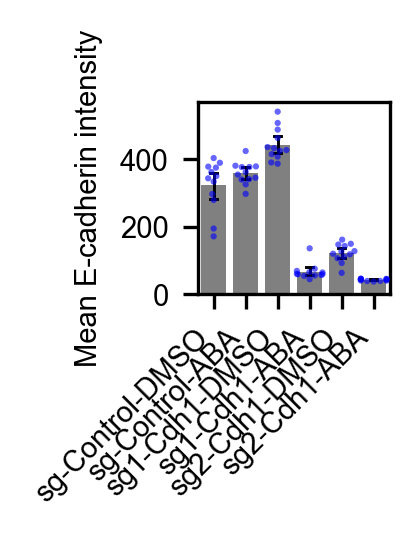

In [11]:
outputPrefix = 'DLD-1-IF-quantification-sg-Cdh1-Ecad'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width=0.8
fig_height=0.8
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

plot_order=['sg-Control-DMSO', 'sg-Control-ABA', 'sg1-Cdh1-DMSO', 'sg1-Cdh1-ABA', 'sg2-Cdh1-DMSO', 'sg2-Cdh1-ABA']


ax = sns.swarmplot(x='groups', y='mean_intensity_Ecad', data=df, order=plot_order,
                   color="blue", size=1.5, alpha=.6)

ax = sns.barplot(x='groups', y='mean_intensity_Ecad', data=df, order=plot_order,
                 color="Gray", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci=95)


# plt.ylim(0, yMax)
# plt.yticks(yTicks)

ax.set_xlabel(None)
ax.set_ylabel('Mean E-cadherin intensity')

ax.set_xticklabels(labels=plot_order, rotation=45, ha="right")

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [12]:
tukeyTest(df.mean_intensity_Ecad, df.groups, alpha=0.05)


Summary of test:
             Multiple Comparison of Means - Tukey HSD, FWER=0.05            
     group1          group2      meandiff p-adj    lower     upper   reject
---------------------------------------------------------------------------
 sg-Control-ABA sg-Control-DMSO  -35.5651  0.295  -85.0321    13.902  False
 sg-Control-ABA    sg1-Cdh1-ABA -292.4751  0.001 -341.9421  -243.008   True
 sg-Control-ABA   sg1-Cdh1-DMSO   84.9187  0.001   35.4517  134.3858   True
 sg-Control-ABA    sg2-Cdh1-ABA -316.7919  0.001 -366.2589 -267.3249   True
 sg-Control-ABA   sg2-Cdh1-DMSO  -236.793  0.001   -286.26 -187.3259   True
sg-Control-DMSO    sg1-Cdh1-ABA   -256.91  0.001  -306.377  -207.443   True
sg-Control-DMSO   sg1-Cdh1-DMSO  120.4838  0.001   71.0168  169.9508   True
sg-Control-DMSO    sg2-Cdh1-ABA -281.2268  0.001 -330.6938 -231.7598   True
sg-Control-DMSO   sg2-Cdh1-DMSO -201.2279  0.001 -250.6949 -151.7609   True
   sg1-Cdh1-ABA   sg1-Cdh1-DMSO  377.3938  0.001  327.9268  426.8608  

In [13]:
# Read in background data measured in Image J
#
# Background fluorescence intensity was measured by drawing a box where no cells were present

folder = '../data/DLD-1-Western-and-IF-data/'
f = folder + 'D193-D301-D304-b1integrin-Ecad-for-background-estimation-mean-intensity-5403.txt'
df = pd.read_csv(f, header=0, sep='\t')

mean_BG_Ecad = df.mean_BG_intensity_Ecad.mean()
print('The mean background intensity of E-cadherin channel is: ', mean_BG_Ecad)

mean_BG_b1int = df.mean_BG_intensity_b1int.mean()
print('The mean background intensity of beta1-integrin channel is: ', mean_BG_b1int)

df.head()


The mean background intensity of E-cadherin channel is:  121.10717
The mean background intensity of beta1-integrin channel is:  110.66803999999999


,file_name,mean_BG_intensity_NLS_mNG,mean_BG_intensity_Ecad,mean_BG_intensity_b1int
0,D193-ABA-561-NLS-mSL-561-Ecad-647-b1integrin-0...,108.0019,120.0081,110.6855
1,D193-ABA-561-NLS-mSL-561-Ecad-647-b1integrin-0...,108.8665,121.1460,111.4819
2,D193-DMSO-561-NLS-mSL-561-Ecad-647-b1integrin-...,108.2293,136.8454,115.7213
3,D301-ABA-561-NLS-mSL-561-Ecad-647-b1integrin-0...,107.9857,117.2130,108.8999
4,D301-ABA-561-NLS-mSL-561-Ecad-647-b1integrin-0...,108.0562,121.1378,109.7799


In [14]:
# Read in E-cadherin and beta1-integrin immunofluorescence quantification data measured in Image J
#
# The mean fluorescent intensity of the entire filed of view (FOV) were measured,
# since most FOVs are confluent with cells

folder = '../data/DLD-1-Western-and-IF-data/'
f = folder + 'D193-D301-D304-b1integrin-Ecad-for-quantification-mean-intensity-38.txt'
df = pd.read_csv(f, header=0, sep='\t')

# There are 6 groups in this data set
#
# Group 1: sg-Control, DMSO
# Group 2: sg-Control, ABA
# Group 3: sg1-Itgb1, DMSO
# Group 4: sg1-Itgb1, ABA
# Group 5: sg2-Itgb1, DMSO
# Group 6: sg2-Itgb1, ABA
df['groups'] = ['sg-Control-ABA']*12 + ['sg-Control-DMSO']*12 + ['sg1-Itgb1-ABA']*12 + \
                ['sg1-Itgb1-DMSO']*12 + ['sg2-Itgb1-ABA']*12 + ['sg2-Itgb1-DMSO']*12

df.mean_intensity_Ecad = df.mean_intensity_Ecad - mean_BG_Ecad
df.mean_intensity_b1int = df.mean_intensity_b1int - mean_BG_b1int

# df.head()
df.tail()


,file_name,mean_intensity_NLS_mNG,mean_intensity_Ecad,mean_intensity_b1int,groups
67,D304-DMSO-561-NLS-mSL-561-Ecad-647-b1integrin-...,553.1685,456.80953,567.00896,sg2-Itgb1-DMSO
68,D304-DMSO-561-NLS-mSL-561-Ecad-647-b1integrin-...,513.7174,449.33643,634.46166,sg2-Itgb1-DMSO
69,D304-DMSO-561-NLS-mSL-561-Ecad-647-b1integrin-...,559.5021,386.10873,343.64836,sg2-Itgb1-DMSO
70,D304-DMSO-561-NLS-mSL-561-Ecad-647-b1integrin-...,907.5498,306.76503,343.65236,sg2-Itgb1-DMSO
71,D304-DMSO-561-NLS-mSL-561-Ecad-647-b1integrin-...,420.2569,435.34193,529.63876,sg2-Itgb1-DMSO


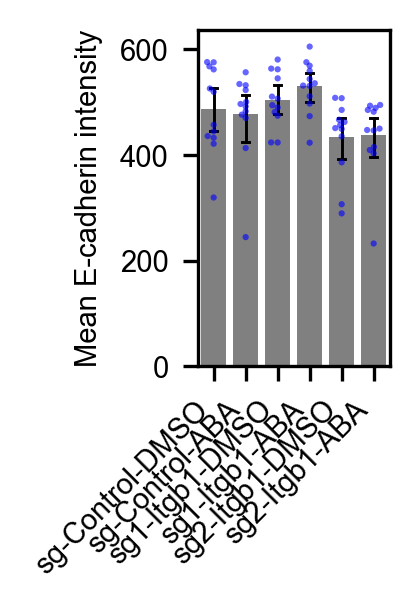

In [15]:
outputPrefix = 'DLD-1-IF-quantification-sg-Itgb1-Ecad'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width=0.8
fig_height=1.4
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

plot_order=['sg-Control-DMSO', 'sg-Control-ABA', 'sg1-Itgb1-DMSO', 'sg1-Itgb1-ABA', 'sg2-Itgb1-DMSO', 'sg2-Itgb1-ABA']


ax = sns.swarmplot(x='groups', y='mean_intensity_Ecad', data=df, order=plot_order,
                   color="blue", size=1.5, alpha=.6)

ax = sns.barplot(x='groups', y='mean_intensity_Ecad', data=df, order=plot_order,
                 color="Gray", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci=95)


# plt.ylim(0, yMax)
# plt.yticks(yTicks)

ax.set_xlabel(None)
ax.set_ylabel('Mean E-cadherin intensity')

ax.set_xticklabels(labels=plot_order, rotation=45, ha="right")

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


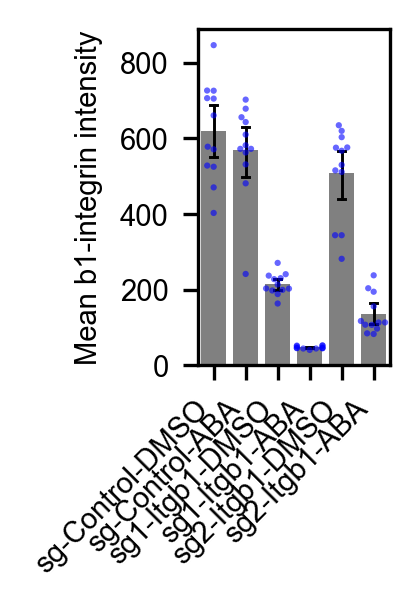

In [16]:
outputPrefix = 'DLD-1-IF-quantification-sg-Itgb1-beta1-integrin'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width=0.8
fig_height=1.4
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

plot_order=['sg-Control-DMSO', 'sg-Control-ABA', 'sg1-Itgb1-DMSO', 'sg1-Itgb1-ABA', 'sg2-Itgb1-DMSO', 'sg2-Itgb1-ABA']


ax = sns.swarmplot(x='groups', y='mean_intensity_b1int', data=df, order=plot_order,
                   color="blue", size=1.5, alpha=.6)

ax = sns.barplot(x='groups', y='mean_intensity_b1int', data=df, order=plot_order,
                 color="Gray", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci=95)


# plt.ylim(0, yMax)
# plt.yticks(yTicks)

ax.set_xlabel(None)
ax.set_ylabel('Mean b1-integrin intensity')

ax.set_xticklabels(labels=plot_order, rotation=45, ha="right")

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [17]:
# Read in background data measured in Image J
#
# Background fluorescence intensity was measured by drawing a box where no cells were present

folder = '../data/DLD-1-Western-and-IF-data/'
f = folder + '191025-D193-D267-D266-b1integrin-for-background-estimation-BG-mean-intensity-130.txt'
df = pd.read_csv(f, header=0, sep='\t')

mean_BG_b1int = df.mean_BG_intensity_b1int.mean()
print('The mean background intensity of beta1-integrin channel is: ', mean_BG_b1int)

df.head()


The mean background intensity of beta1-integrin channel is:  41.61395


,file_name,mean_BG_intensity_b1int
0,193-ABA-1-MIP,43.7391
1,193-ABA-2-MIP,44.9391
2,193-DMSO-1-MIP,36.1576
3,193-DMSO-2-MIP,36.8695
4,266-ABA-1-MIP,46.5791


In [18]:
# Read in beta1-integrin immunofluorescence quantification data measured in Image J
#
# The mean fluorescent intensity of the cell-positive area segmented from DAPI were measured

folder = '../data/DLD-1-Western-and-IF-data/'
f = folder + '191025-D193-D267-D266-b1integrin-for-quantification-mean-intensity-5674.txt'
df = pd.read_csv(f, header=0, sep='\t')

# There are 6 groups in this data set
#
# Group 1: sg-Control, DMSO
# Group 2: sg-Control, ABA
# Group 3: sg1-Cdh1, DMSO
# Group 4: sg1-Cdh1, ABA
# Group 5: sg2-Cdh1, DMSO
# Group 6: sg2-Cdh1, ABA
df['groups'] = ['sg-Control-ABA']*6 + ['sg-Control-DMSO']*6 + ['sg2-Cdh1-ABA']*6 + \
                ['sg2-Cdh1-DMSO']*6 + ['sg1-Cdh1-ABA']*6 + ['sg1-Cdh1-DMSO']*6

df.mean_intensity_b1int = df.mean_intensity_b1int - mean_BG_b1int

# df.head()
df.tail()


,file_name,mean_intensity_b1int,groups
31,267-DMSO-2-MIP,467.37255,sg1-Cdh1-DMSO
32,267-DMSO-3-MIP,469.55305,sg1-Cdh1-DMSO
33,267-DMSO-4-MIP,543.17895,sg1-Cdh1-DMSO
34,267-DMSO-5-MIP,424.98715,sg1-Cdh1-DMSO
35,267-DMSO-6-MIP,488.25855,sg1-Cdh1-DMSO


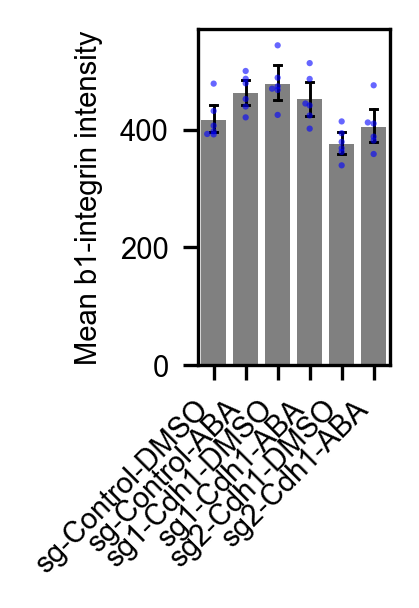

In [19]:
outputPrefix = 'DLD-1-IF-quantification-sg-Cdh1-beta1-integrin'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width=0.8
fig_height=1.4
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

plot_order=['sg-Control-DMSO', 'sg-Control-ABA', 'sg1-Cdh1-DMSO', 'sg1-Cdh1-ABA', 'sg2-Cdh1-DMSO', 'sg2-Cdh1-ABA']

ax = sns.swarmplot(x='groups', y='mean_intensity_b1int', data=df, order=plot_order,
                   color="blue", size=1.5, alpha=.6)

ax = sns.barplot(x='groups', y='mean_intensity_b1int', data=df, order=plot_order,
                 color="Gray", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci=95)


# plt.ylim(0, yMax)
# plt.yticks(yTicks)

ax.set_xlabel(None)
ax.set_ylabel('Mean b1-integrin intensity')

ax.set_xticklabels(labels=plot_order, rotation=45, ha="right")

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [20]:
tukeyTest(df.mean_intensity_b1int, df.groups, alpha=0.05)


Summary of test:
            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
     group1          group2      meandiff p-adj    lower    upper   reject
--------------------------------------------------------------------------
 sg-Control-ABA sg-Control-DMSO  -46.3969 0.2349 -108.3818   15.588  False
 sg-Control-ABA    sg1-Cdh1-ABA  -11.0611    0.9   -73.046  50.9238  False
 sg-Control-ABA   sg1-Cdh1-DMSO    15.019    0.9  -46.9658  77.0039  False
 sg-Control-ABA    sg2-Cdh1-ABA  -58.4575 0.0736 -120.4424   3.5274  False
 sg-Control-ABA   sg2-Cdh1-DMSO  -86.6478 0.0024 -148.6327  -24.663   True
sg-Control-DMSO    sg1-Cdh1-ABA   35.3358 0.5186  -26.6491  97.3206  False
sg-Control-DMSO   sg1-Cdh1-DMSO   61.4159 0.0533    -0.569 123.4008  False
sg-Control-DMSO    sg2-Cdh1-ABA  -12.0606    0.9  -74.0455  49.9242  False
sg-Control-DMSO   sg2-Cdh1-DMSO   -40.251 0.3806 -102.2358  21.7339  False
   sg1-Cdh1-ABA   sg1-Cdh1-DMSO   26.0802 0.7686  -35.9047   88.065  False
   sg1-